In [1]:
import sys
import json
import pandas as pd

# Load datasets
games = pd.read_csv("games-full.csv", dtype={'game_id': str})
player_stats = pd.read_csv("player_game_stats-full-fixed.csv", dtype={'game_id': str})

# Filter for regular season games only
games = games[games["game_id"].str.startswith("002")]
player_stats = player_stats[player_stats["game_id"].str.startswith("002")]

# Melt games dataframe for team-wise games played
games_melted = games.melt(id_vars=["game_id", "season_year"], 
                          value_vars=["home_team_id", "away_team_id"],
                          value_name="team_id")

# Count games played per team per season
games_played = games_melted.groupby(["season_year", "team_id"])["game_id"].nunique().reset_index()
games_played.rename(columns={"game_id": "games_played"}, inplace=True)

# Parse nested player stats
player_stats['player_game_stats'] = player_stats['player_game_stats'].apply(json.loads)
player_stats = player_stats.dropna(subset=['player_game_stats']).copy()
player_stats = pd.concat(
    [player_stats.drop(columns=['player_game_stats']), 
     player_stats['player_game_stats'].apply(pd.Series)], 
    axis=1
)

# Merge season info
player_stats = player_stats.merge(games[['game_id', 'season_year']], on='game_id', how='left')

# Define stat columns
stats_columns = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 
                 'OREB', 'DREB', 'AST', 'STL', 'BLK', 
                 'TO', 'PTS']

# Filter and aggregate player stats
player_stats = player_stats[['season_year', 'game_id', 'team_id'] + stats_columns]
team_stats = player_stats.groupby(['game_id', 'team_id'])[stats_columns].sum().reset_index()

# Merge with games to determine home/away teams
team_stats = team_stats.merge(
    games[['game_id', 'season_year', 'home_team_id', 'away_team_id']], 
    on='game_id', 
    how='left'
)

# Separate home and away stats
home_stats = team_stats[team_stats['team_id'] == team_stats['home_team_id']]
away_stats = team_stats[team_stats['team_id'] == team_stats['away_team_id']]

# Rename columns
home_stats = home_stats.rename(columns={col: col + "_home" for col in stats_columns}).drop(columns=['team_id'])
away_stats = away_stats.rename(columns={col: col + "_away" for col in stats_columns}).drop(columns=['team_id'])

# Merge into one row per game
game_stats = home_stats.merge(away_stats, on=['game_id', 'season_year', 'home_team_id', 'away_team_id'], how='inner')

# Compute outcome, 1 if home team wins, 0 otherwise
game_stats["total_points"] = (game_stats["PTS_home"] + game_stats["PTS_away"]).astype(int)

# Create a dataframe of winners
winners = pd.DataFrame({
    "game_id": game_stats["game_id"],
    "winner_team_id": game_stats["home_team_id"].where(game_stats["total_points"] == 1, game_stats["away_team_id"])
})

# Convert to long format for modeling
home_team_stats = game_stats[["game_id", "season_year", "home_team_id"] + [col for col in game_stats.columns if col.endswith("_home")]].copy()
away_team_stats = game_stats[["game_id", "season_year", "away_team_id"] + [col for col in game_stats.columns if col.endswith("_away")]].copy()

home_team_stats.columns = ["game_id", "season_year", "team_id"] + [col.replace("_home", "") for col in home_team_stats.columns[3:]]
away_team_stats.columns = ["game_id", "season_year", "team_id"] + [col.replace("_away", "") for col in away_team_stats.columns[3:]]

long_stats = pd.concat([home_team_stats, away_team_stats], axis=0).sort_values(["team_id", "season_year", "game_id"])

# Sort by game_date in chonological order before calculating rolling averages
long_stats = long_stats.merge(games[['game_id', 'game_date']], on='game_id', how='left')
long_stats = long_stats.sort_values('game_date').reset_index(drop=True)

wl_count = long_stats.copy()

# Merge the winner lookup table into the long stats df
wl_count = wl_count.merge(winners, on='game_id', how='left')

# Calculate wins and losses for each team up to the current game
wl_count["won_game"] = (wl_count["team_id"] == wl_count["winner_team_id"]).astype(int)
wl_count["games_so_far"] = (
    wl_count.groupby(['team_id', 'season_year'])
    .cumcount()
)
wl_count["wins"] = (
    wl_count.groupby(['team_id', 'season_year'])["won_game"]
    .cumsum() - wl_count["won_game"]
).fillna(0).astype(int)
wl_count["losses"] = (
    wl_count["games_so_far"] - wl_count["wins"]
).clip(lower=0).astype(int)

# Compute number of possessions for each team (from NBA.com)
long_stats["POSS"] = (
    (long_stats["FGA"] + 0.44 * long_stats["FTA"] - long_stats["OREB"] + long_stats["TO"])
)
long_stats["POSS"] = long_stats["POSS"].clip(lower=0)  # Ensure there are no negative possession values

# Compute per 100 possession stats
per_100_columns = [stat + "_100" for stat in stats_columns]
for stat in stats_columns:
    long_stats[stat + "_100"] = 100 * long_stats[stat] / long_stats["POSS"]

# Add the possession stat to per_100_columns so we can compute rolling averages for it
per_100_columns.append("POSS")

# Compute rolling averages of per-100-possession stats
def compute_rolling_averages(group):
    return group[per_100_columns].shift().expanding().mean()

long_stats_avg = long_stats.copy()
long_stats_avg[per_100_columns] = long_stats.groupby(["team_id", "season_year"], group_keys=False).apply(compute_rolling_averages)
long_stats_avg.drop(columns=stats_columns, inplace=True)

# Fallback: previous season average per-100 stats
prev_season_averages = long_stats.groupby(["team_id", "season_year"])[per_100_columns].mean().reset_index()

def shift_season(season_str):
    start, end = season_str.split("-")
    next_start = str(int(start) + 1)
    next_end = str(int(end[-2:]) + 1).zfill(2)
    return f"{next_start}-{next_end}"

prev_season_averages["season_year"] = prev_season_averages["season_year"].apply(shift_season)

long_stats_avg = long_stats_avg.merge(
    prev_season_averages,
    on=["team_id", "season_year"],
    how="left",
    suffixes=("", "_fallback")
)

for stat in per_100_columns:
    long_stats_avg[stat] = long_stats_avg[stat].fillna(long_stats_avg[f"{stat}_fallback"])
    long_stats_avg.drop(columns=[f"{stat}_fallback"], inplace=True)

long_stats_avg.dropna(inplace=True)

last_5_games = long_stats.merge(wl_count[['game_id', 'team_id', 'wins', 'losses', 'won_game']], 
                              on=['game_id', 'team_id'], how='left')

# Define which columns to roll over
rolling_features = per_100_columns  # exclude 'won_game' for mean calculations

# Rolling mean stats over the last 5 games (using only previous games)
rolling_means = (
    last_5_games.groupby(['team_id', 'season_year'])[rolling_features]
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=5).mean())
)

rolling_wins = (
    last_5_games.groupby(['team_id', 'season_year'])['won_game']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=5).sum())
    .fillna(0).astype(int)
)

rolling_losses = (
    last_5_games.groupby(['team_id', 'season_year'])['won_game']
    .transform(lambda x: (1 - x.shift(1)).rolling(window=5, min_periods=5).sum())
    .fillna(0).astype(int)
)

# Merge based on index (team_id, season_year, original index inside group)
rolling_5 = pd.concat(
    [
        rolling_means.rename(columns={col: f"rolling_{col}_last5" for col in rolling_means.columns}),
        rolling_wins.rename('rolling_wins_last5'),
        rolling_losses.rename('rolling_losses_last5')
    ],
    axis=1
)

# Now merge back safely (indexes match)
last_5_games = pd.concat([last_5_games, rolling_5], axis=1)

# Merge previous season averages as fallback
last_5_games = last_5_games.merge(
    prev_season_averages[['team_id', 'season_year'] + per_100_columns],
    on=['team_id', 'season_year'],
    how='left',
    suffixes=('', '_fallback')
)

# Fill rolling columns using fallback columns
for col in [f"rolling_{stat}_last5" for stat in per_100_columns] + ['rolling_wins_last5', 'rolling_losses_last5']:
    fallback_col = col.replace('rolling_', '').replace('_last5', '') + '_fallback'
    if fallback_col in last_5_games.columns:
        last_5_games[col] = last_5_games[col].fillna(last_5_games[fallback_col])

# Drop all *_fallback columns
last_5_games.drop(columns=[c for c in last_5_games.columns if c.endswith('_fallback')], inplace=True)

# Compute opponent average allowed stats
opponent_stats = long_stats[["game_id", "team_id"] + per_100_columns].copy()
opponent_stats = opponent_stats.rename(columns={col: col + "_opp" for col in per_100_columns})
team_opponent_stats = long_stats[["game_id", "team_id", "season_year"]].merge(
    opponent_stats, on="game_id", suffixes=("", "_opp"))
team_opponent_stats = team_opponent_stats[team_opponent_stats["team_id"] != team_opponent_stats["team_id_opp"]]

# Rolling average of allowed stats
opp_stat_cols = [stat + "_opp" for stat in per_100_columns]
team_opponent_stats_avg = team_opponent_stats.copy()
team_opponent_stats_avg[opp_stat_cols] = team_opponent_stats.groupby(["team_id", "season_year"], group_keys=False)[opp_stat_cols].apply(lambda g: g.shift().expanding().mean())

# Fallback from previous season
prev_opp_season_averages = team_opponent_stats.groupby(["team_id", "season_year"])[opp_stat_cols].mean().reset_index()
prev_opp_season_averages["season_year"] = prev_opp_season_averages["season_year"].apply(shift_season)

team_opponent_stats_avg = team_opponent_stats_avg.merge(
    prev_opp_season_averages,
    on=["team_id", "season_year"],
    how="left",
    suffixes=("", "_fallback")
)

for stat in opp_stat_cols:
    team_opponent_stats_avg[stat] = team_opponent_stats_avg[stat].fillna(team_opponent_stats_avg[f"{stat}_fallback"])
    team_opponent_stats_avg.drop(columns=[f"{stat}_fallback"], inplace=True)

team_opponent_stats_avg.dropna(inplace=True)

# Add rolling stats for the last 5 games
# First select only the rolling columns + game_id and team_id
rolling_cols = ['game_id', 'team_id'] + [col for col in last_5_games.columns if col.startswith('rolling_')]

# Pull out the rolling columns
rolling_features_df = last_5_games[rolling_cols]

# Now merge rolling_features with long_stats_avg df
long_stats_avg = long_stats_avg.merge(rolling_features_df, on=["game_id", "team_id"], how='left')

# Drop the columns from the first 5 games for each team in the 2018-19 season
long_stats_avg.dropna(inplace=True)

# Home/Away features
home_features = long_stats_avg.merge(game_stats[['game_id', 'home_team_id']], left_on=['game_id', 'team_id'], right_on=['game_id', 'home_team_id'], how='inner').drop(columns=['home_team_id'])
away_features = long_stats_avg.merge(game_stats[['game_id', 'away_team_id']], left_on=['game_id', 'team_id'], right_on=['game_id', 'away_team_id'], how='inner').drop(columns=['away_team_id'])

# Add wins and losses to home and away features
home_features = home_features.merge(wl_count[['game_id', 'team_id', 'wins', 'losses']], on=['game_id', 'team_id'], how='left')
away_features = away_features.merge(wl_count[['game_id', 'team_id', 'wins', 'losses']], on=['game_id', 'team_id'], how='left')

# Rename the columns for home and away features
home_features = home_features.rename(columns={stat: f"{stat}_home" for stat in per_100_columns} | {'wins': 'home_wins', 'losses': 'home_losses'})
away_features = away_features.rename(columns={stat: f"{stat}_away" for stat in per_100_columns} | {'wins': 'away_wins', 'losses': 'away_losses'})

# Merge features
ml_df = home_features.merge(away_features, on=["game_id", "game_date"], how="inner").merge(
    game_stats[["game_id", "total_points"]],
    on="game_id", how="inner"
)
ml_df = ml_df.drop_duplicates('game_id')

# Clean up
ml_df = ml_df.drop(columns=["team_id_x", "team_id_y", "season_year_x", "season_year_y", "game_date"], errors='ignore')
X = ml_df.drop(columns=["game_id", "total_points"])
y = ml_df["total_points"]

X.head(), y.head()


C:\Users\trito\AppData\Local\Temp\ipykernel_660\3587751311.py:121: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_stats_avg[per_100_columns] = long_stats.groupby(["team_id", "season_year"], group_keys=False).apply(compute_rolling_averages)


(   POSS_home  FGM_100_home  FGA_100_home  FG3M_100_home  FG3A_100_home  \
 0    104.616     37.818021     90.726604      10.524255      30.282339   
 1    107.448     39.276927     86.690922      11.129930      32.023147   
 2    102.344     39.020980     89.016174       6.962544      21.655478   
 3    107.128     41.374974     87.049891      15.000102      39.004092   
 4    106.200     38.220997     87.160867      12.374537      37.556396   
 
    FTM_100_home  FTA_100_home  OREB_100_home  DREB_100_home  AST_100_home  \
 0     15.349630     20.265482      10.397545      30.937494     19.091514   
 1     16.731516     22.178083       8.704236      37.186441     26.595641   
 2     17.736460     21.950757      12.698639      31.126805     19.864309   
 3     14.998695     19.727588      10.766482      40.746248     25.472534   
 4     17.611126     23.384478      10.721150      30.124649     24.388114   
 
    ...  rolling_AST_100_last5_y  rolling_STL_100_last5_y  \
 0  ...          

(6460, 64)
(6460,)
(6460, 64)
(6460,)
Training Mean Squared Error (MSE): 355.66
Test Mean Squared Error (MSE): 347.14
Training R² Score: 0.1424
Test R² Score: 0.1099


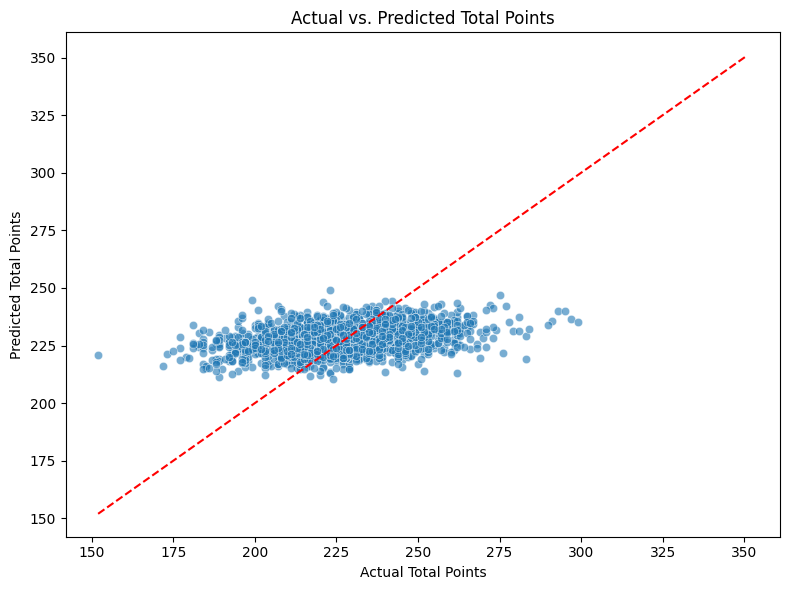

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Scaling the features
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

X_scaled = np.log1p(X_scaled)  # Apply log transformation to the scaled features

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

print(X_train.shape)
print(y_train.shape)

# Apply Z-score to remove outlier scores from training data
y_zscore = zscore(y_train)
mask = np.abs(y_zscore) < 10  # Create mask to remove ~50/8000 scores that are outliers
X_train = X_train[mask]
y_train = y_train[mask]

print(X_train.shape)
print(y_train.shape)

model = Ridge(alpha=4.0)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate MSE and R² score for both training and test sets
y_train_pred = model.predict(X_train)  # Predictions on training set
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)

# Print performance metrics
print("Training Mean Squared Error (MSE):", round(mse_train, 2))
print("Test Mean Squared Error (MSE):", round(mse_test, 2))
print("Training R² Score:", round(r2_train, 4))
print("Test R² Score:", round(r2_test, 4))

# Plot predictions vs actual for the test set
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")
plt.title("Actual vs. Predicted Total Points")
plt.tight_layout()
plt.show()


(6460, 64)
(6460,)
(6460, 64)
(6460,)
Training Mean Squared Error (MSE): 162.22
Test Mean Squared Error (MSE): 373.2
Training R² Score: 0.6088
Test R² Score: 0.0431


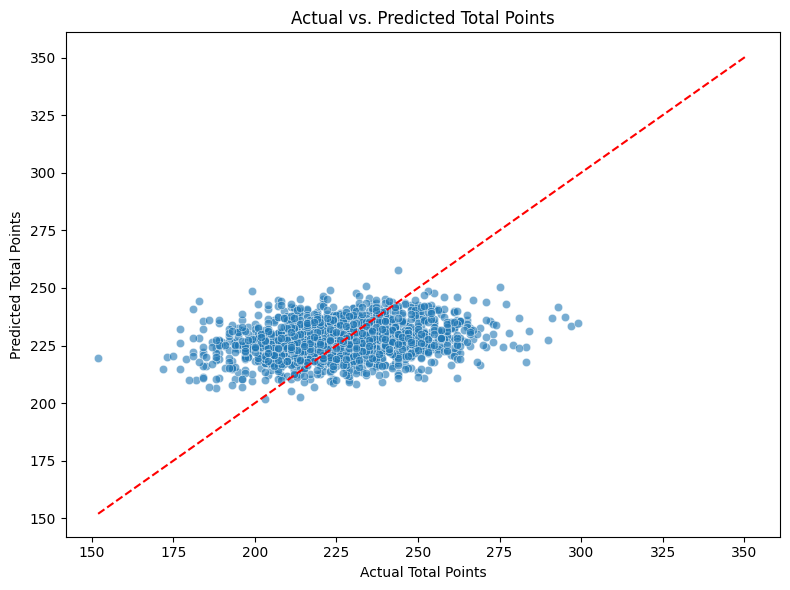

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor  # Import Gradient Boosting Regressor

# Scaling the features
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

X_scaled = np.log1p(X_scaled)  # Apply log transformation to the scaled features

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

print(X_train.shape)
print(y_train.shape)

# Apply Z-score to remove outlier scores from training data
y_zscore = zscore(y_train)
mask = np.abs(y_zscore) < 10  # Create mask to remove ~50/8000 scores that are outliers
X_train = X_train[mask]
y_train = y_train[mask]

print(X_train.shape)
print(y_train.shape)

# Initialize Gradient Boosting Regressor model
model = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.05)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate MSE and R² score for both training and test sets
y_train_pred = model.predict(X_train)  # Predictions on training set
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)

# Print performance metrics
print("Training Mean Squared Error (MSE):", round(mse_train, 2))
print("Test Mean Squared Error (MSE):", round(mse_test, 2))
print("Training R² Score:", round(r2_train, 4))
print("Test R² Score:", round(r2_test, 4))

# Plot predictions vs actual for the test set
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")
plt.title("Actual vs. Predicted Total Points")
plt.tight_layout()
plt.show()


(6460, 64)
(6460,)
(6419, 64)
(6419,)
Training Mean Squared Error (MSE): 318.35
Test Mean Squared Error (MSE): 355.04
Training R² Score: 0.1764
Test R² Score: 0.0896


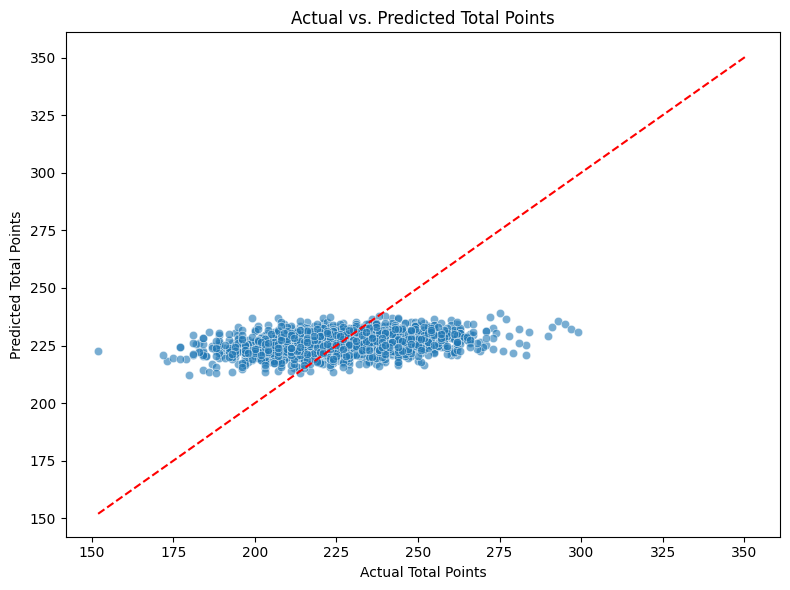

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor  # Import Gradient Boosting Regressor

# Scaling the features
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

X_scaled = np.log1p(X_scaled)  # Apply log transformation to the scaled features

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

print(X_train.shape)
print(y_train.shape)

# Apply Z-score to remove outlier scores from training data
y_zscore = zscore(y_train)
mask = np.abs(y_zscore) < 2.8  # Create mask to remove ~50/8000 scores that are outliers
X_train = X_train[mask]
y_train = y_train[mask]

print(X_train.shape)
print(y_train.shape)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}


# Initialize Gradient Boosting Regressor model
model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate MSE and R² score for both training an d test sets
y_train_pred = model.predict(X_train)  # Predictions on training set
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)

# Print performance metrics
print("Training Mean Squared Error (MSE):", round(mse_train, 2))
print("Test Mean Squared Error (MSE):", round(mse_test, 2))
print("Training R² Score:", round(r2_train, 4))
print("Test R² Score:", round(r2_test, 4))

# Plot predictions vs actual for the test set
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")
plt.title("Actual vs. Predicted Total Points")
plt.tight_layout()
plt.show()


In [27]:
import xgboost as xgb

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predictions and performance
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost MSE:", round(mse_xgb, 2), "| R²:", round(r2_xgb, 4))


XGBoost MSE: 374.86 | R²: 0.0388


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters:
 {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Mean Squared Error (MSE): 366.38
R² Score: 0.1221


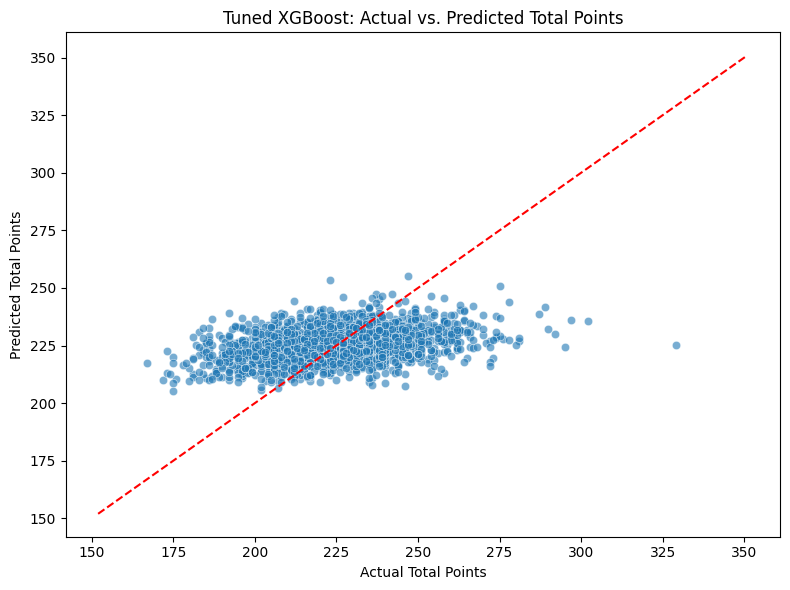

In [28]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter grid
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 4, 5, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_alpha": [0, 0.01, 0.1, 1.0],
    "reg_lambda": [1.0, 1.5, 2.0]
}

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,  # number of combinations to try
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

# Best estimator
best_model = random_search.best_estimator_
print("Best Parameters:\n", random_search.best_params_)

# Evaluate
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", round(mse, 2))
print("R² Score:", round(r2, 4))

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")
plt.title("Tuned XGBoost: Actual vs. Predicted Total Points")
plt.tight_layout()
plt.show()


In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define your parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
}

# Initialize base model
gbr = GradientBoostingRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best model from grid search
best_gbr = grid_search.best_estimator_

# Predict
y_pred = best_gbr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Test MSE:", mse)
print("Test R²:", r2)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Test MSE: 355.1743950383898
Test R²: 0.08929188021620571


Ensemble Mean Squared Error (MSE): 347.01
Ensemble R² Score: 0.1102


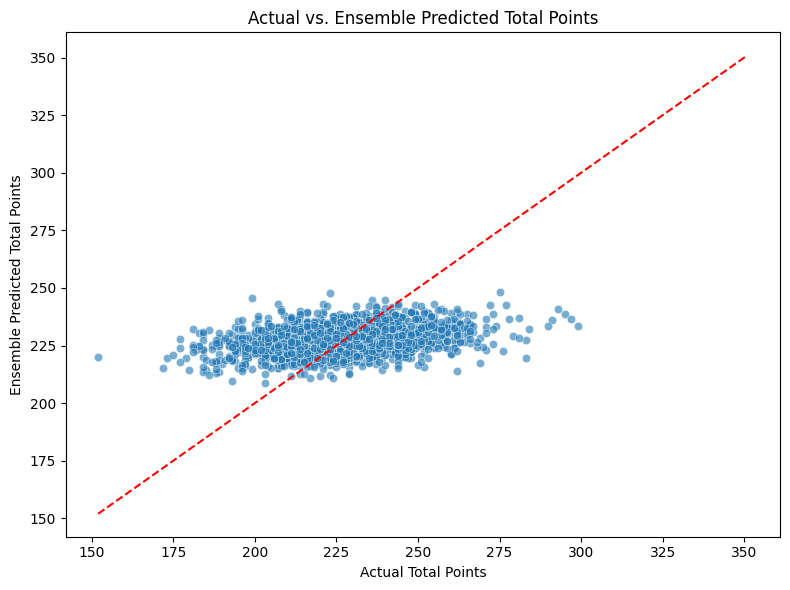

In [34]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.log1p(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

ridge = Ridge(alpha=4.0)
gbr = GradientBoostingRegressor()

ridge.fit(X_train, y_train)
gbr.fit(X_train, y_train)

ridge_preds = ridge.predict(X_test)
gbr_preds = gbr.predict(X_test)

ensemble_preds = (ridge_preds + gbr_preds) / 2

mse_ensemble = mean_squared_error(y_test, ensemble_preds)
r2_ensemble = r2_score(y_test, ensemble_preds)

print("Ensemble Mean Squared Error (MSE):", round(mse_ensemble, 2))
print("Ensemble R² Score:", round(r2_ensemble, 4))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=ensemble_preds, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel("Actual Total Points")
plt.ylabel("Ensemble Predicted Total Points")
plt.title("Actual vs. Ensemble Predicted Total Points")
plt.tight_layout()
plt.show()


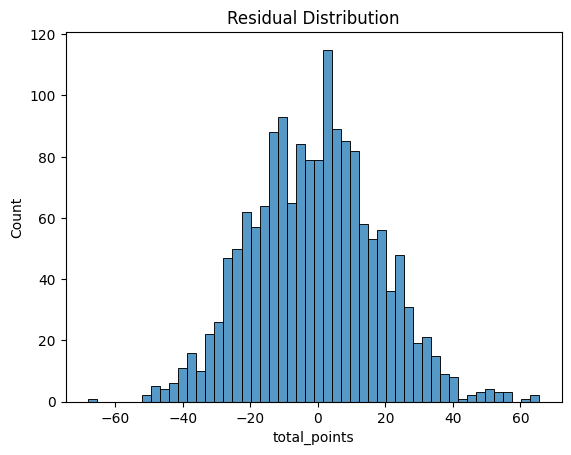

In [35]:
residuals = y_test - ensemble_preds
sns.histplot(residuals, bins=50)
plt.title("Residual Distribution")
plt.show()
